STAT 453: Intro to Deep Learning and Generative Models (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

In [ ]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch,pandas,matplotlib

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.20.0

torch     : 1.9.0a0+d819a21
pandas    : 1.2.2
matplotlib: 3.3.4



# Linear Regression with Gradient Descent

![](https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L05/code/figures/adaline-concept.png?raw=1)

Note that linear regression and Adaline are very similar. The only difference is that we apply a threshold function for converting the outputs from continuous targets for predictions. The derivative and training procedure are identical to Adaline though. You can compare the two notebooks (this one and `adaline-sgd.ipynb`) side by side as shown below to see the relationship:

![](https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L05/code/figures/adaline-vs-linreg.png?raw=1)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

<br>
<br>

## Load & Prepare a Toy Dataset

In [21]:
df = pd.read_csv('/content/linreg-data.csv', index_col=0)
df.tail()

,x1,x2,y
995,-0.942094,-0.835856,-22.324428
996,1.222445,-0.403177,-52.121493
997,-0.112466,-1.688230,-57.043196
998,-0.403459,-0.412272,-27.701833
999,0.021351,-0.499017,-9.804714


In [22]:
# Assign features and target

X = torch.tensor(df[['x1', 'x2']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.float)

# Shuffling & train/test split

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent70 = int(shuffle_idx.size(0)*0.7)

X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

<br>
<br>

## Implement Linear Regression Model

In [23]:
class LinearRegression1():
    def __init__(self, num_features):
        self.num_features = num_features
        '''self.weights = torch.zeros(num_features, 1,
                                   dtype=torch.float)'''
         # Initialize weights from a uniform distribution in range [-1,1]
        self.weights = torch.zeros(num_features, 1, dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def forward(self, x):
        netinputs = torch.add(torch.mm(x, self.weights), self.bias)
        activations = netinputs
        return activations.view(-1)

    def backward(self, x, yhat, y):

        grad_loss_yhat = 2*(yhat - y)

        grad_yhat_weights = x
        grad_yhat_bias = 1.

        # Chain rule: inner times outer
        grad_loss_weights =  torch.mm(grad_yhat_weights.t(),
                                         grad_loss_yhat.view(-1, 1)) / y.size(0)

        grad_loss_bias = torch.sum(grad_yhat_bias*grad_loss_yhat) / y.size(0)

        # return negative gradient
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

<br>
<br>

## Define Training and Evaluation Functions

In [31]:
####################################################
##### Training and evaluation wrappers
###################################################

def loss(yhat, y):
    return torch.mean((yhat - y)**2)


'''def train(model, x, y, num_epochs, learning_rate=0.01):
    cost = []
    for e in range(num_epochs):

        #### Compute outputs ####
        yhat = model.forward(x)

        #### Compute gradients ####
        negative_grad_w, negative_grad_b = model.backward(x, yhat, y)

        #### Update weights ####
        model.weights += learning_rate * negative_grad_w
        model.bias += learning_rate * negative_grad_b

        #### Logging ####
        yhat = model.forward(x) # not that this is a bit wasteful here
        curr_loss = loss(yhat, y)
        print('Epoch: %03d' % (e+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost'''

def train(model, x_train, y_train, x_test, y_test,
          num_epochs, learning_rate=0.01, batch_size=32):

    train_mse_hist = []
    test_mse_hist = []
    n = y_train.size(0)

    for e in range(num_epochs):

        # Shuffle data before each epoch
        idx = torch.randperm(n)
        x_shuffled = x_train[idx]
        y_shuffled = y_train[idx]

        # mini-batch SGD
        for start in range(0, n, batch_size):
            end = start + batch_size
            xb = x_shuffled[start:end]
            yb = y_shuffled[start:end]

            yhat = model.forward(xb)
            neg_grad_w, neg_grad_b = model.backward(xb, yhat, yb)

            model.weights += learning_rate * neg_grad_w
            model.bias += learning_rate * neg_grad_b

        # ---- Compute train & test error after each epoch ----
        with torch.no_grad():
            train_pred = model.forward(x_train)
            test_pred = model.forward(x_test)

            train_mse = loss(train_pred, y_train)
            test_mse = loss(test_pred, y_test)

        print('Epoch: %03d' % (e+1), end="")
        print(' | Train MSE: %.5f' % train_mse, end="")
        print(' | Test MSE: %.5f' % test_mse)

        train_mse_hist.append(train_mse)
        test_mse_hist.append(test_mse)

    return train_mse_hist, test_mse_hist

'''
Author has a comment "# not that this is a bit wasteful here", fix this?
The author recomputes model.forward(x) twice per epoch:
first one:
#### Compute outputs ####
        yhat = model.forward(x)
second one:
#### Logging ####
        yhat = model.forward(x)
even though nothing changed between the two calls.

 so the solution is:
 doing mini-batch SGD, do not recompute forward, only compute full train/test loss once per epoch:
 with torch.no_grad():
            train_pred = model.forward(x_train)
            test_pred = model.forward(x_test)

'''

'\nAuthor has a comment "# not that this is a bit wasteful here", fix this?\nThe author recomputes model.forward(x) twice per epoch:\nfirst one:\n#### Compute outputs ####\n        yhat = model.forward(x)\nsecond one:\n#### Logging ####\n        yhat = model.forward(x) \neven though nothing changed between the two calls.\n\n so the solution is: \n doing mini-batch SGD, do not recompute forward, only compute full train/test loss once per epoch:\n with torch.no_grad():\n            train_pred = model.forward(x_train)\n            test_pred = model.forward(x_test)   \n\n'

<br>
<br>

## Train Linear Regression Model

In [32]:
model = LinearRegression1(num_features=X_train.size(1))

'''cost = train(model,
             X_train, y_train,
             num_epochs=100,
             learning_rate=0.05,
             batch_size=16) '''

# After training, plot both the train error and test error after each epoch
train_mse_hist, test_mse_hist = train(
    model,
    X_train, y_train,
    X_test, y_test,
    num_epochs=100,
    learning_rate=0.05,
    batch_size=16
)



Epoch: 001 | Train MSE: 372.41660 | Test MSE: 408.23169
Epoch: 002 | Train MSE: 373.67465 | Test MSE: 404.70157
Epoch: 003 | Train MSE: 383.49081 | Test MSE: 428.58081
Epoch: 004 | Train MSE: 372.65082 | Test MSE: 406.06100
Epoch: 005 | Train MSE: 371.63977 | Test MSE: 406.56860
Epoch: 006 | Train MSE: 375.00436 | Test MSE: 409.42365
Epoch: 007 | Train MSE: 373.11121 | Test MSE: 408.79959
Epoch: 008 | Train MSE: 372.51541 | Test MSE: 405.83099
Epoch: 009 | Train MSE: 375.38467 | Test MSE: 417.82037
Epoch: 010 | Train MSE: 374.99133 | Test MSE: 415.71329
Epoch: 011 | Train MSE: 372.87073 | Test MSE: 409.80585
Epoch: 012 | Train MSE: 373.45764 | Test MSE: 404.19589
Epoch: 013 | Train MSE: 373.98532 | Test MSE: 410.48279
Epoch: 014 | Train MSE: 372.75000 | Test MSE: 404.47729
Epoch: 015 | Train MSE: 373.59329 | Test MSE: 413.49973
Epoch: 016 | Train MSE: 372.09851 | Test MSE: 409.80112
Epoch: 017 | Train MSE: 372.21655 | Test MSE: 408.11072
Epoch: 018 | Train MSE: 372.90338 | Test MSE: 41

<br>
<br>

## Evaluate Linear Regression Model

### Plot MSE

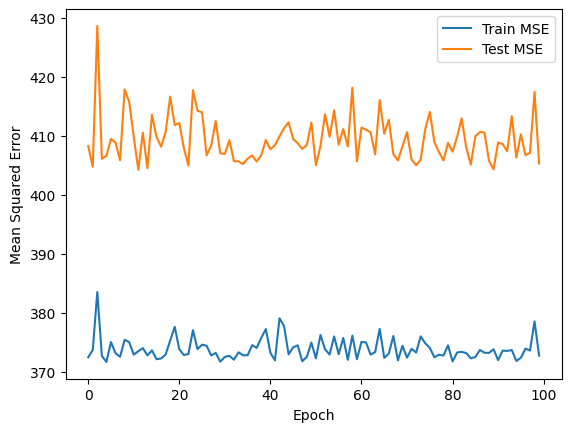

In [33]:
'''plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()'''
plt.plot(range(len(train_mse_hist)), train_mse_hist, label='Train MSE')
plt.plot(range(len(test_mse_hist)), test_mse_hist, label='Test MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
train_pred = model.forward(X_train)
test_pred = model.forward(X_test)

print('Train MSE: %.5f' % loss(train_pred, y_train))
print('Test MSE: %.5f' % loss(test_pred, y_test))

Train MSE: 371.61035
Test MSE: 406.88412


<br>
<br>

### Compare with analytical solution

In [ ]:
print('Weights', model.weights)
print('Bias', model.bias)

Weights tensor([[ 0.3623],
        [37.8790]])
Bias tensor([-0.5464])


In [ ]:
def analytical_solution(x, y):
    Xb = torch.cat( (torch.ones((x.size(0), 1)), x), dim=1)
    w = torch.zeros(x.size(1))
    z = torch.inverse(torch.matmul(Xb.t(), Xb))
    params = torch.matmul(z, torch.matmul(Xb.t(), y))
    b, w = torch.tensor([params[0]]), params[1:].view(x.size(1), 1)
    return w, b

w, b = analytical_solution(X_train, y_train)
print('Analytical weights', w)
print('Analytical bias', b)

Analytical weights tensor([[ 0.3624],
        [37.8801]])
Analytical bias tensor([-0.5464])


<br>
<br>

## (Ungraded) HW Exercises

Modify the `train()` function such that the dataset is shuffled prior to each epoch. Do you see a difference -- Yes/No? Try to come up with an explanation for your observation.

